### Import Neccessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import seaborn as sns

### Read the first dataset

In [2]:
df = pd.read_csv('Traffic_Incidents_20250117.csv')

df['START_DT'] = pd.to_datetime(df['START_DT'],format='mixed')
df['MODIFIED_DT'] = pd.to_datetime(df['MODIFIED_DT'],format='mixed')
df.head(3)

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,Count,id,Point
0,Westbound 16 Avenue at Deerfoot Trail NE,Stalled vehicle. Partially blocking the right...,2022-06-21 07:31:40,2022-06-21 07:33:16,NE,-114.026687,51.067485,1,2022-06-21T07:31:4051.067485129276236-114.0266...,POINT (-114.02668672232672 51.067485129276236)
1,11 Avenue and 4 Street SW,Traffic incident. Blocking multiple lanes,2022-06-21 04:02:11,2022-06-21 04:12:38,SW,-114.071481,51.042624,1,2022-06-21T04:02:1151.04262449261462-114.07148...,POINT (-114.07148057660925 51.04262449261462)
2,68 Street and Memorial Drive E,Traffic incident.,2022-06-20 23:53:08,2022-06-20 23:55:42,NE,-113.935553,51.052474,1,2022-06-20T23:53:0851.0524735056658-113.935553...,POINT (-113.935553325751 51.0524735056658)


In [3]:
df.columns

Index(['INCIDENT INFO', 'DESCRIPTION', 'START_DT', 'MODIFIED_DT', 'QUADRANT',
       'Longitude', 'Latitude', 'Count', 'id', 'Point'],
      dtype='object')

## Data Cleaning

### Create coulmns for Year, Month and Day

In [4]:
df['Year'] = df['START_DT'].dt.year
df['Month'] = df['START_DT'].dt.month_name()
df['Day'] = df['START_DT'].dt.day_name()
df.head(2)

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,Count,id,Point,Year,Month,Day
0,Westbound 16 Avenue at Deerfoot Trail NE,Stalled vehicle. Partially blocking the right...,2022-06-21 07:31:40,2022-06-21 07:33:16,NE,-114.026687,51.067485,1,2022-06-21T07:31:4051.067485129276236-114.0266...,POINT (-114.02668672232672 51.067485129276236),2022,June,Tuesday
1,11 Avenue and 4 Street SW,Traffic incident. Blocking multiple lanes,2022-06-21 04:02:11,2022-06-21 04:12:38,SW,-114.071481,51.042624,1,2022-06-21T04:02:1151.04262449261462-114.07148...,POINT (-114.07148057660925 51.04262449261462),2022,June,Tuesday


### Pick only the year 2024

In [5]:
df = df[df['Year'] == 2024]

### Create a column for the weekend

In [6]:
# Add a column indicating whether each date falls on a weekend.
def weekend_or_not(day):
    return day in ['Saturday','Sunday']

df['Weekend?'] = df['Day'].apply(weekend_or_not)
df.head(2)

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,Count,id,Point,Year,Month,Day,Weekend?
499,14 Street and 16 Avenue NW,Traffic incident.,2024-11-12 18:14:13,2024-11-12 19:18:05,NW,-114.096037,51.067018,1,2024-11-12T18:14:1351.06701776006629-114.09603...,POINT (-114.09603722789542 51.06701776006629),2024,November,Tuesday,False
637,42 Avenue and 6 Street SE,Traffic incident.,2024-08-10 12:23:33,2024-08-10 12:58:32,SE,-114.049847,51.015928,1,2024-08-10T12:23:3351.01592778071953-114.04984...,POINT (-114.04984663534405 51.01592778071953),2024,August,Saturday,True


## Data Analysis

### Accidents count during the day 

         Day  Daily_counts
0     Monday          1050
1    Tuesday          1187
2  Wednesday          1238
3   Thursday          1211
4     Friday          1214
5   Saturday           898
6     Sunday           695


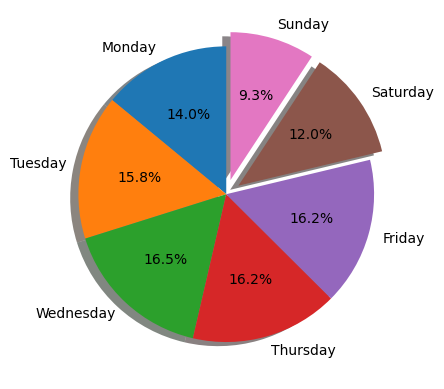

In [7]:

daily_accidents = df.groupby(['Day']).agg(
    Daily_counts = ('Count','sum')
).reset_index()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_accidents['Day'] = pd.Categorical(daily_accidents['Day'], categories=day_order, ordered=True)
daily_accidents = daily_accidents.sort_values('Day').reset_index(drop=True)
print(daily_accidents)

# Let's plot
explode = (0, 0, 0, 0, 0 ,0.1 ,0.1)
fig, ax = plt.subplots()
ax.pie(daily_accidents['Daily_counts'], explode=explode, labels=daily_accidents['Day'], autopct='%1.1f%%',
       shadow={'ox': -0.04, 'edgecolor': 'none', 'shade': 0.9}, startangle=90)
plt.show()

### Number of the accidents based on quadrant

  QUADRANT  Total_count
0       NE         2229
1       NW         1600
2       SE         2294
3       SW         1370


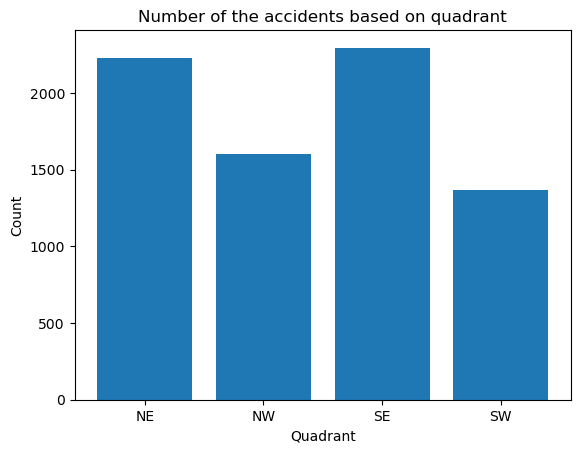

In [8]:
quadrant = df.groupby(['QUADRANT']).agg(
    Total_count = ('Count','sum')
).reset_index()
print(quadrant)
plt.bar( x = quadrant['QUADRANT'], height=quadrant['Total_count'])
plt.xlabel('Quadrant')
plt.ylabel('Count')
plt.title('Number of the accidents based on quadrant')
plt.show()

### Number of accidents per hour

According to the **https://www.calgary.com/blog/driving-calgary-ab/** traffic congestion peaks between 7:00–9:00 a.m. and 4:00–6:00 p.m.

In [9]:
# What time of the day, most accidents accure
df['Hour'] = df['START_DT'].dt.hour
df.head(2)

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,Count,id,Point,Year,Month,Day,Weekend?,Hour
499,14 Street and 16 Avenue NW,Traffic incident.,2024-11-12 18:14:13,2024-11-12 19:18:05,NW,-114.096037,51.067018,1,2024-11-12T18:14:1351.06701776006629-114.09603...,POINT (-114.09603722789542 51.06701776006629),2024,November,Tuesday,False,18
637,42 Avenue and 6 Street SE,Traffic incident.,2024-08-10 12:23:33,2024-08-10 12:58:32,SE,-114.049847,51.015928,1,2024-08-10T12:23:3351.01592778071953-114.04984...,POINT (-114.04984663534405 51.01592778071953),2024,August,Saturday,True,12


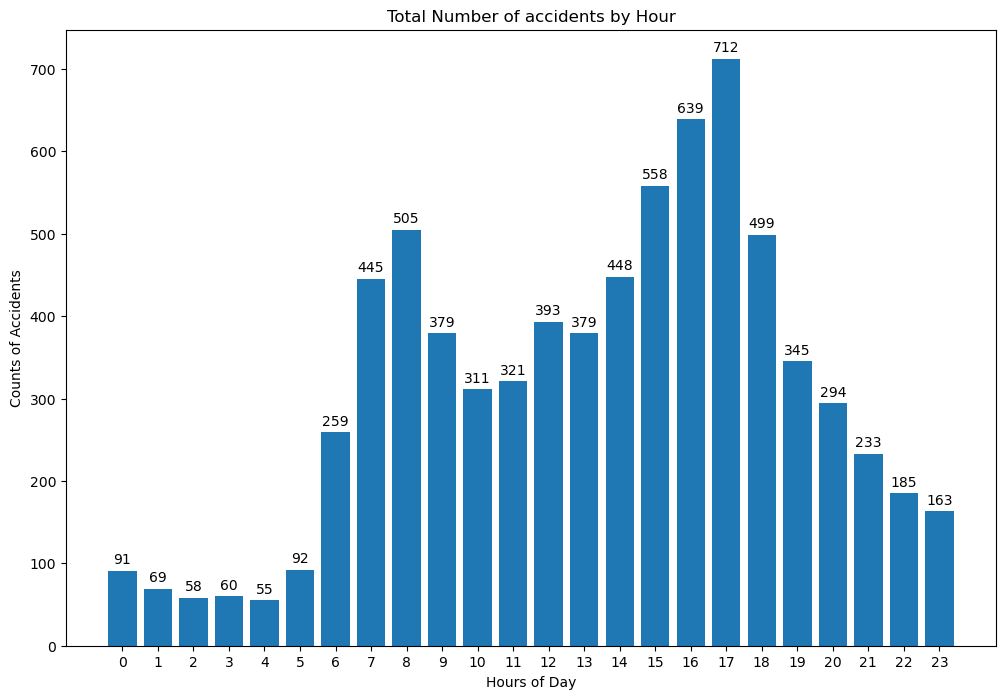

In [10]:
acci_by_hour = df.groupby(['Hour']).agg(
    count_per_hour = ('Count','sum')
).reset_index()

#display(acci_by_hour)
plt.figure(figsize=(12,8))
bars = plt.bar(data = acci_by_hour,x= acci_by_hour['Hour'], height=acci_by_hour['count_per_hour'])
plt.bar_label(bars, fmt='%.0f', padding=3, fontsize=10)
plt.xlabel('Hours of Day')
plt.ylabel('Counts of Accidents')
plt.title('Total Number of accidents by Hour')
plt.xticks(list(range(0,24)))
plt.show()

### Rush hour or not????

In [11]:
def rush_hour(hour):
    return hour in [7,8,9,16,17,18]

df['Rush Hour'] = df['Hour'].apply(rush_hour)
df.head(2)

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,Count,id,Point,Year,Month,Day,Weekend?,Hour,Rush Hour
499,14 Street and 16 Avenue NW,Traffic incident.,2024-11-12 18:14:13,2024-11-12 19:18:05,NW,-114.096037,51.067018,1,2024-11-12T18:14:1351.06701776006629-114.09603...,POINT (-114.09603722789542 51.06701776006629),2024,November,Tuesday,False,18,True
637,42 Avenue and 6 Street SE,Traffic incident.,2024-08-10 12:23:33,2024-08-10 12:58:32,SE,-114.049847,51.015928,1,2024-08-10T12:23:3351.01592778071953-114.04984...,POINT (-114.04984663534405 51.01592778071953),2024,August,Saturday,True,12,False


   Rush Hour  Rush_Hour_acci_counts
0      False                   4314
1       True                   3179


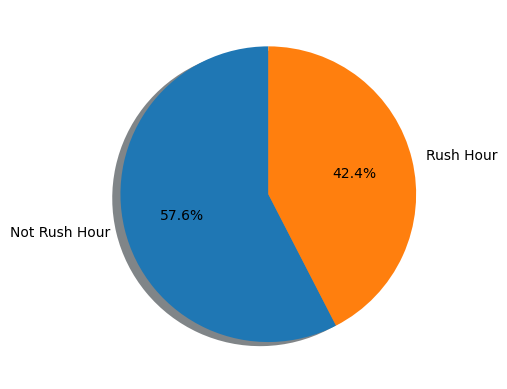

In [12]:
rush_hour = df.groupby(['Rush Hour']).agg(
    Rush_Hour_acci_counts = ('Count','sum')
).reset_index()

print(rush_hour)
labels = 'Not Rush Hour', 'Rush Hour'
sizes = rush_hour['Rush_Hour_acci_counts']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels,autopct='%1.1f%%',
       shadow={'ox': -0.04, 'edgecolor': 'none', 'shade': 0.9}, startangle=90)
plt.show()

This means **42%** of the accidents during the day, occure in the **6h rush hours**

### Seasonality

**Create a season column**

In [13]:
def month_to_season(month):
    if month in ['December', 'January', 'February']:
        return 'Winter'
    elif month in ['March', 'April', 'May']:
        return 'Spring'
    elif month in ['June', 'July', 'August']:
        return 'Summer'
    elif month in ['September', 'October', 'November']:
        return 'Fall'

# Apply the function to the 'Month' column
df['Season'] = df['Month'].apply(month_to_season)

df.head(3)

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,Count,id,Point,Year,Month,Day,Weekend?,Hour,Rush Hour,Season
499,14 Street and 16 Avenue NW,Traffic incident.,2024-11-12 18:14:13,2024-11-12 19:18:05,NW,-114.096037,51.067018,1,2024-11-12T18:14:1351.06701776006629-114.09603...,POINT (-114.09603722789542 51.06701776006629),2024,November,Tuesday,False,18,True,Fall
637,42 Avenue and 6 Street SE,Traffic incident.,2024-08-10 12:23:33,2024-08-10 12:58:32,SE,-114.049847,51.015928,1,2024-08-10T12:23:3351.01592778071953-114.04984...,POINT (-114.04984663534405 51.01592778071953),2024,August,Saturday,True,12,False,Summer
1944,50 Street and 17 Avenue SE,Traffic incident.,2024-10-21 14:33:50,2024-10-21 14:48:15,SE,-113.961373,51.037929,1,2024-10-21T14:33:5051.03792916406439-113.96137...,POINT (-113.96137262047222 51.03792916406439),2024,October,Monday,False,14,False,Fall


In [14]:
seasonal_accidents = df.groupby(['Season']).agg(
    season_acc = ('Count','sum')
).reset_index()

seasonal_accidents

,Season,season_acc
0,Fall,2174
1,Spring,1699
2,Summer,1769
3,Winter,1851


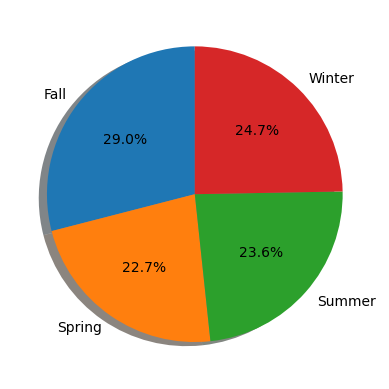

In [15]:
labels = seasonal_accidents['Season']
sizes = seasonal_accidents['season_acc']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels,autopct='%1.1f%%',
       shadow={'ox': -0.04, 'edgecolor': 'none', 'shade': 0.9}, startangle=90)
plt.show()

## Preparing the weather dataset to merge with the accident dataset 

In [16]:
df2 = pd.read_csv('en_climate_daily_AB_3031092_2024_P1D.csv')
df2

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,-114.01,51.12,CALGARY INTL A,3031092,2024-01-01,2024,1,1,NaN,4.2,...,0.0,NaN,2.0,NaN,NaN,NaN,NaN,M,NaN,M
1,-114.01,51.12,CALGARY INTL A,3031092,2024-01-02,2024,1,2,NaN,3.1,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,M,NaN,M
2,-114.01,51.12,CALGARY INTL A,3031092,2024-01-03,2024,1,3,NaN,-4.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,M,NaN,M
3,-114.01,51.12,CALGARY INTL A,3031092,2024-01-04,2024,1,4,NaN,4.4,...,0.0,NaN,0.0,NaN,NaN,NaN,28.0,NaN,35.0,NaN
4,-114.01,51.12,CALGARY INTL A,3031092,2024-01-05,2024,1,5,NaN,3.9,...,0.0,NaN,0.0,NaN,0.0,T,34.0,NaN,51.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,-114.01,51.12,CALGARY INTL A,3031092,2024-12-27,2024,12,27,NaN,6.2,...,0.0,NaN,0.0,NaN,NaN,NaN,30.0,NaN,46.0,NaN
362,-114.01,51.12,CALGARY INTL A,3031092,2024-12-28,2024,12,28,NaN,NaN,...,0.0,NaN,0.0,NaN,0.0,T,NaN,M,NaN,M
363,-114.01,51.12,CALGARY INTL A,3031092,2024-12-29,2024,12,29,NaN,0.2,...,0.0,T,0.0,T,0.0,T,NaN,M,NaN,M
364,-114.01,51.12,CALGARY INTL A,3031092,2024-12-30,2024,12,30,NaN,-2.9,...,1.4,NaN,0.8,NaN,1.0,NaN,NaN,M,NaN,M


### Create new columns with datetime format

In [17]:
df2.drop(columns=['Year', 'Month','Day']) # dropping these three columns, since they already exist in the df

df2['Date/Time'] = pd.to_datetime(df2['Date/Time'])

df2.head(2)

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,-114.01,51.12,CALGARY INTL A,3031092,2024-01-01,2024,1,1,NaN,4.2,...,0.0,NaN,2.0,NaN,NaN,NaN,NaN,M,NaN,M
1,-114.01,51.12,CALGARY INTL A,3031092,2024-01-02,2024,1,2,NaN,3.1,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,M,NaN,M


**In order to merge df and df2, I will need to create a similar Date/Time column in df**

In [18]:
df['Date/Time'] = df['START_DT'].dt.date
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.head(2)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7493 entries, 499 to 51858
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   INCIDENT INFO  7493 non-null   object        
 1   DESCRIPTION    7493 non-null   object        
 2   START_DT       7493 non-null   datetime64[ns]
 3   MODIFIED_DT    7493 non-null   datetime64[ns]
 4   QUADRANT       7493 non-null   object        
 5   Longitude      7493 non-null   float64       
 6   Latitude       7493 non-null   float64       
 7   Count          7493 non-null   int64         
 8   id             7493 non-null   object        
 9   Point          7493 non-null   object        
 10  Year           7493 non-null   int32         
 11  Month          7493 non-null   object        
 12  Day            7493 non-null   object        
 13  Weekend?       7493 non-null   bool          
 14  Hour           7493 non-null   int32         
 15  Rush Hour      7493 non

In [19]:
df = df.merge(df2,how = 'left', on = 'Date/Time')
df.head()

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,Count,id,Point,...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,14 Street and 16 Avenue NW,Traffic incident.,2024-11-12 18:14:13,2024-11-12 19:18:05,NW,-114.096037,51.067018,1,2024-11-12T18:14:1351.06701776006629-114.09603...,POINT (-114.09603722789542 51.06701776006629),...,0.0,NaN,0.0,NaN,NaN,NaN,25.0,NaN,44.0,NaN
1,42 Avenue and 6 Street SE,Traffic incident.,2024-08-10 12:23:33,2024-08-10 12:58:32,SE,-114.049847,51.015928,1,2024-08-10T12:23:3351.01592778071953-114.04984...,POINT (-114.04984663534405 51.01592778071953),...,0.0,NaN,0.0,NaN,NaN,NaN,14.0,NaN,45.0,NaN
2,50 Street and 17 Avenue SE,Traffic incident.,2024-10-21 14:33:50,2024-10-21 14:48:15,SE,-113.961373,51.037929,1,2024-10-21T14:33:5051.03792916406439-113.96137...,POINT (-113.96137262047222 51.03792916406439),...,0.6,NaN,0.9,NaN,0.0,T,34.0,NaN,67.0,NaN
3,19 Street and 100 Avenue NE,Traffic incident.,2024-05-06 21:25:48,2024-05-06 21:27:14,NE,-114.013182,51.143480,1,2024-05-06T21:25:4851.143479998275986-114.0131...,POINT (-114.01318161895406 51.143479998275986),...,0.0,NaN,1.9,NaN,NaN,NaN,29.0,NaN,51.0,NaN
4,9 Avenue and 10 Street SE,Traffic incident.,2024-01-19 00:13:40,2024-01-19 00:14:28,SE,-114.037853,51.042464,1,2024-01-19T00:13:4051.04246366287656-114.03785...,POINT (-114.03785255798742 51.04246366287656),...,0.0,NaN,0.0,NaN,12.0,NaN,17.0,NaN,32.0,NaN


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7493 entries, 0 to 7492
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   INCIDENT INFO              7493 non-null   object        
 1   DESCRIPTION                7493 non-null   object        
 2   START_DT                   7493 non-null   datetime64[ns]
 3   MODIFIED_DT                7493 non-null   datetime64[ns]
 4   QUADRANT                   7493 non-null   object        
 5   Longitude                  7493 non-null   float64       
 6   Latitude                   7493 non-null   float64       
 7   Count                      7493 non-null   int64         
 8   id                         7493 non-null   object        
 9   Point                      7493 non-null   object        
 10  Year_x                     7493 non-null   int32         
 11  Month_x                    7493 non-null   object        
 12  Day_x 

# From now on we only work on the df, since it includes both dataframes

In [21]:
df

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,Count,id,Point,...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,14 Street and 16 Avenue NW,Traffic incident.,2024-11-12 18:14:13,2024-11-12 19:18:05,NW,-114.096037,51.067018,1,2024-11-12T18:14:1351.06701776006629-114.09603...,POINT (-114.09603722789542 51.06701776006629),...,0.0,NaN,0.0,NaN,NaN,NaN,25.0,NaN,44.0,NaN
1,42 Avenue and 6 Street SE,Traffic incident.,2024-08-10 12:23:33,2024-08-10 12:58:32,SE,-114.049847,51.015928,1,2024-08-10T12:23:3351.01592778071953-114.04984...,POINT (-114.04984663534405 51.01592778071953),...,0.0,NaN,0.0,NaN,NaN,NaN,14.0,NaN,45.0,NaN
2,50 Street and 17 Avenue SE,Traffic incident.,2024-10-21 14:33:50,2024-10-21 14:48:15,SE,-113.961373,51.037929,1,2024-10-21T14:33:5051.03792916406439-113.96137...,POINT (-113.96137262047222 51.03792916406439),...,0.6,NaN,0.9,NaN,0.0,T,34.0,NaN,67.0,NaN
3,19 Street and 100 Avenue NE,Traffic incident.,2024-05-06 21:25:48,2024-05-06 21:27:14,NE,-114.013182,51.143480,1,2024-05-06T21:25:4851.143479998275986-114.0131...,POINT (-114.01318161895406 51.143479998275986),...,0.0,NaN,1.9,NaN,NaN,NaN,29.0,NaN,51.0,NaN
4,9 Avenue and 10 Street SE,Traffic incident.,2024-01-19 00:13:40,2024-01-19 00:14:28,SE,-114.037853,51.042464,1,2024-01-19T00:13:4051.04246366287656-114.03785...,POINT (-114.03785255798742 51.04246366287656),...,0.0,NaN,0.0,NaN,12.0,NaN,17.0,NaN,32.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7488,Eastbound 12 Avenue approaching 5 Street SW,Traffic incident. Blocking multiple lanes,2024-12-31 23:18:29,2024-12-31 23:33:06,SW,-114.075319,51.041751,1,2024-12-31T23:18:2951.041750526936205-114.0753...,POINT (-114.07531894488655 51.041750526936205),...,2.8,NaN,2.8,NaN,1.0,NaN,NaN,M,NaN,M
7489,Southbound Stoney Trail at Nose Hill Drive NW,Traffic incident. Blocking multiple lanes,2024-12-31 21:37:18,2024-12-31 23:33:06,NW,-114.224335,51.108817,1,2024-12-31T21:37:1851.10881729053866-114.22433...,POINT (-114.2243351115667 51.10881729053866),...,2.8,NaN,2.8,NaN,1.0,NaN,NaN,M,NaN,M
7490,Southbound Deerfoot Trail at Anderson Road SE,Traffic incident.,2024-12-31 22:16:11,2025-01-01 00:19:14,SE,-114.026634,50.954065,1,2024-12-31T22:16:1150.954064789730026-114.0266...,POINT (-114.02663423800188 50.954064789730026),...,2.8,NaN,2.8,NaN,1.0,NaN,NaN,M,NaN,M
7491,Southbound Deerfoot Trail at Memorial Drive SE,Traffic incident. Blocking multiple lanes,2024-12-31 23:10:22,2025-01-01 00:34:43,SE,-114.013631,51.045357,1,2024-12-31T23:10:2251.04535659010204-114.01363...,POINT (-114.0136314886718 51.04535659010204),...,2.8,NaN,2.8,NaN,1.0,NaN,NaN,M,NaN,M


In [22]:
df['Total Snow (cm)'].isna().sum()

37

### Using KNN to fill the missing values

In [23]:
imputer = KNNImputer(n_neighbors=5, add_indicator=True)

df['Total Snow (cm)'] = imputer.fit_transform(df[['Total Snow (cm)']])
df['Total Rain (mm)'] = imputer.fit_transform(df[['Total Rain (mm)']])
df.head(5)

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,Count,id,Point,...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,14 Street and 16 Avenue NW,Traffic incident.,2024-11-12 18:14:13,2024-11-12 19:18:05,NW,-114.096037,51.067018,1,2024-11-12T18:14:1351.06701776006629-114.09603...,POINT (-114.09603722789542 51.06701776006629),...,0.0,NaN,0.0,NaN,NaN,NaN,25.0,NaN,44.0,NaN
1,42 Avenue and 6 Street SE,Traffic incident.,2024-08-10 12:23:33,2024-08-10 12:58:32,SE,-114.049847,51.015928,1,2024-08-10T12:23:3351.01592778071953-114.04984...,POINT (-114.04984663534405 51.01592778071953),...,0.0,NaN,0.0,NaN,NaN,NaN,14.0,NaN,45.0,NaN
2,50 Street and 17 Avenue SE,Traffic incident.,2024-10-21 14:33:50,2024-10-21 14:48:15,SE,-113.961373,51.037929,1,2024-10-21T14:33:5051.03792916406439-113.96137...,POINT (-113.96137262047222 51.03792916406439),...,0.6,NaN,0.9,NaN,0.0,T,34.0,NaN,67.0,NaN
3,19 Street and 100 Avenue NE,Traffic incident.,2024-05-06 21:25:48,2024-05-06 21:27:14,NE,-114.013182,51.143480,1,2024-05-06T21:25:4851.143479998275986-114.0131...,POINT (-114.01318161895406 51.143479998275986),...,0.0,NaN,1.9,NaN,NaN,NaN,29.0,NaN,51.0,NaN
4,9 Avenue and 10 Street SE,Traffic incident.,2024-01-19 00:13:40,2024-01-19 00:14:28,SE,-114.037853,51.042464,1,2024-01-19T00:13:4051.04246366287656-114.03785...,POINT (-114.03785255798742 51.04246366287656),...,0.0,NaN,0.0,NaN,12.0,NaN,17.0,NaN,32.0,NaN


In [24]:
df['Total Snow (cm)'].isna().sum()

0

### Rain and snow fall based on the month

#### 1. Rain

In [25]:
rain_month = df.groupby(['Month_x']).agg(
    monthly_rain = ('Total Rain (mm)','sum')
).reset_index()
rain_month

,Month_x,monthly_rain
0,April,127.000000
1,August,1582.444756
2,December,1.800000
3,February,7.200000
4,January,30.000000
5,July,948.200000
6,June,1614.600000
7,March,0.000000
8,May,966.600000
9,November,0.000000


      Month_x  monthly_rain
0     January     30.000000
1    February      7.200000
2       March      0.000000
3       April    127.000000
4         May    966.600000
5        June   1614.600000
6        July    948.200000
7      August   1582.444756
8   September   1929.900000
9     October     10.800000
10   November      0.000000
11   December      1.800000


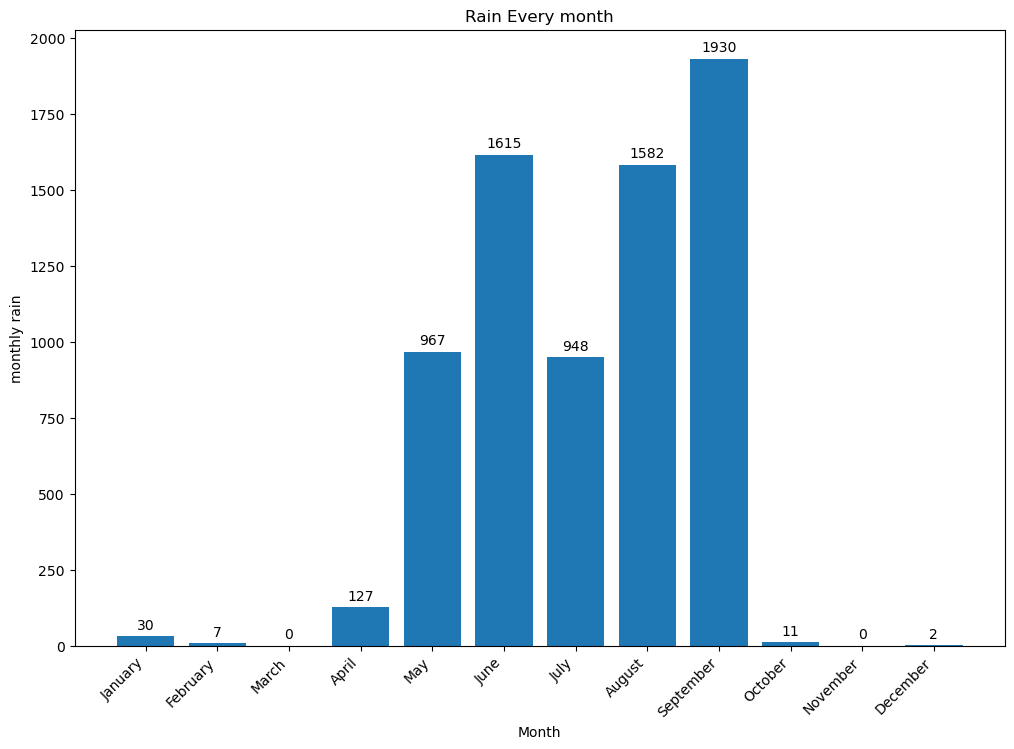

In [26]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November','December']
rain_month['Month_x'] = pd.Categorical(rain_month['Month_x'], categories=month_order, ordered=True)
rain_month = rain_month.sort_values('Month_x').reset_index(drop=True)
print(rain_month)

plt.figure(figsize=(12,8))
bars = plt.bar(data = rain_month,x= rain_month['Month_x'], height=rain_month['monthly_rain'])
plt.bar_label(bars, fmt='%.0f', padding=3, fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Month')
plt.ylabel('monthly rain')
plt.title('Rain Every month')

plt.show()

**Snow**

In [27]:
snow_month = df.groupby(['Month_x']).agg(
    monthly_snow = ('Total Snow (cm)','sum')
).reset_index()
snow_month

,Month_x,monthly_snow
0,April,573.100000
1,August,31.303608
2,December,148.200000
3,February,569.300000
4,January,1072.200000
5,July,0.000000
6,June,0.000000
7,March,2401.900000
8,May,162.800000
9,November,1359.000000


,Month_x,monthly_snow
0,January,1072.200000
1,February,569.300000
2,March,2401.900000
3,April,573.100000
4,May,162.800000
5,June,0.000000
6,July,0.000000
7,August,31.303608
8,September,0.000000
9,October,21.600000


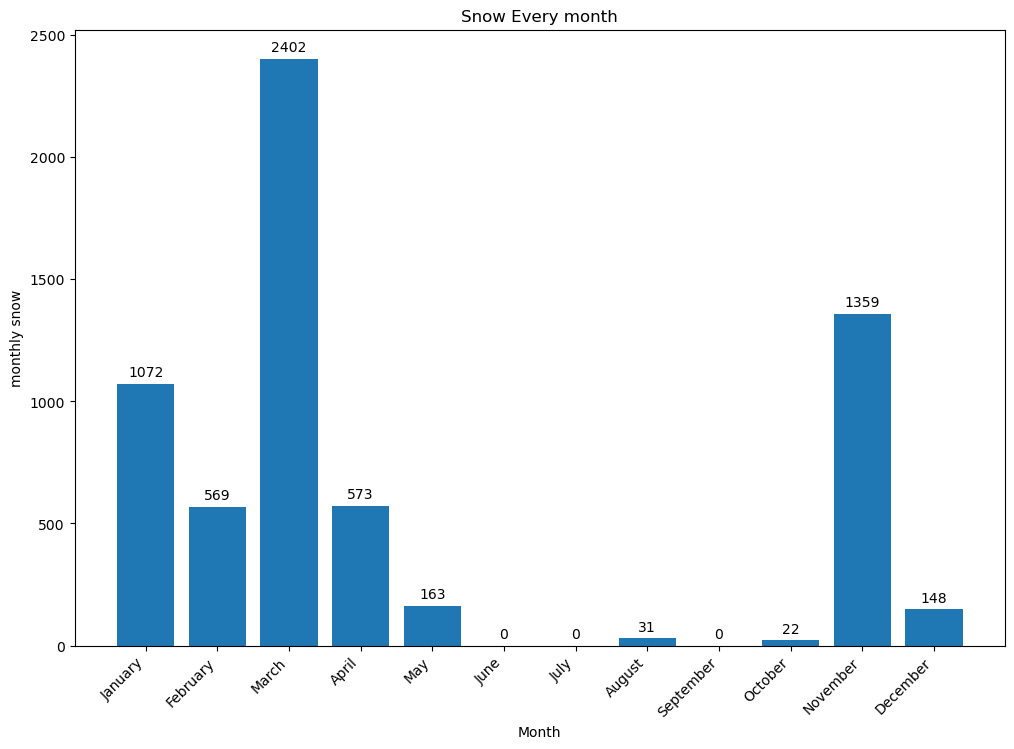

In [28]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November','December']
snow_month['Month_x'] = pd.Categorical(snow_month['Month_x'], categories=month_order, ordered=True)
snow_month = snow_month.sort_values('Month_x').reset_index(drop=True)
display(snow_month)

plt.figure(figsize=(12,8))
bars = plt.bar(data = snow_month,x= snow_month['Month_x'], height=snow_month['monthly_snow'])
plt.bar_label(bars, fmt='%.0f', padding=3, fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Month')
plt.ylabel('monthly snow')
plt.title('Snow Every month')

plt.show()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7493 entries, 0 to 7492
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   INCIDENT INFO              7493 non-null   object        
 1   DESCRIPTION                7493 non-null   object        
 2   START_DT                   7493 non-null   datetime64[ns]
 3   MODIFIED_DT                7493 non-null   datetime64[ns]
 4   QUADRANT                   7493 non-null   object        
 5   Longitude                  7493 non-null   float64       
 6   Latitude                   7493 non-null   float64       
 7   Count                      7493 non-null   int64         
 8   id                         7493 non-null   object        
 9   Point                      7493 non-null   object        
 10  Year_x                     7493 non-null   int32         
 11  Month_x                    7493 non-null   object        
 12  Day_x 

### Let's find the correlation between the accident counts, total snow and total rain

In [30]:
df['Total Rain (cm)'] = df['Total Rain (mm)'] / 10   # rain (mm) --> rain (cm)

df_correlation = df.groupby('Month_x').agg(
    sum_counts = ('Count','sum'),
    monthly_snow = ('Total Snow (cm)','sum'),
    monthly_rain = ('Total Rain (cm)','sum')
).reset_index()

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November','December']
df_correlation['Month_x'] = pd.Categorical(df_correlation['Month_x'], categories=month_order, ordered=True)
df_correlation = df_correlation.sort_values('Month_x').reset_index(drop=True)

df_correlation

,Month_x,sum_counts,monthly_snow,monthly_rain
0,January,767,1072.200000,3.000000
1,February,507,569.300000,0.720000
2,March,686,2401.900000,0.000000
3,April,448,573.100000,12.700000
4,May,565,162.800000,96.660000
5,June,564,0.000000,161.460000
6,July,632,0.000000,94.820000
7,August,573,31.303608,158.244476
8,September,625,0.000000,192.990000
9,October,723,21.600000,1.080000


### Let's try plot this

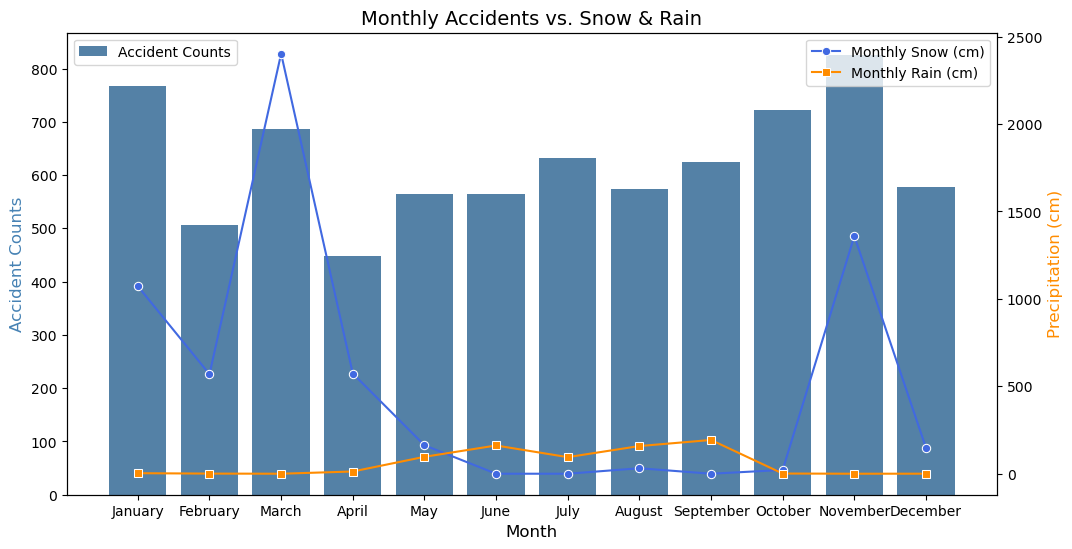

In [31]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for accident counts
sns.barplot(x="Month_x", y="sum_counts", data=df_correlation, ax=ax1, color="steelblue", label="Accident Counts")

# Create a second y-axis
ax2 = ax1.twinx()

# Line plot for snow and rain
sns.lineplot(x="Month_x", y="monthly_snow", data=df_correlation, ax=ax2, marker="o", color="royalblue", label="Monthly Snow (cm)")
sns.lineplot(x="Month_x", y="monthly_rain", data=df_correlation, ax=ax2, marker="s", color="darkorange", label="Monthly Rain (cm)")

# Labels and titles
ax1.set_ylabel("Accident Counts", color="steelblue", fontsize=12)
ax2.set_ylabel("Precipitation (cm)", color="darkorange", fontsize=12)
ax1.set_xlabel("Month", fontsize=12)
ax1.set_title("Monthly Accidents vs. Snow & Rain", fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Show the plot
plt.show()

In [32]:
columns_of_interest = ['sum_counts', 'monthly_snow', 'monthly_rain']
df_corr = df_correlation[columns_of_interest].corr()

display(df_corr)

,sum_counts,monthly_snow,monthly_rain
sum_counts,1.000000,0.435429,-0.269343
monthly_snow,0.435429,1.000000,-0.561272
monthly_rain,-0.269343,-0.561272,1.000000


## Effect of temperature on accidents above and below zero 

In [33]:
def below_zero(temp):
    if temp <= 0:
        return 'Below zero'
    else:
        return 'Above Zero'

df['Below or Above Zero'] = df['Mean Temp (°C)'].apply(below_zero)
df.head(5)

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,Count,id,Point,...,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,Total Rain (cm),Below or Above Zero
0,14 Street and 16 Avenue NW,Traffic incident.,2024-11-12 18:14:13,2024-11-12 19:18:05,NW,-114.096037,51.067018,1,2024-11-12T18:14:1351.06701776006629-114.09603...,POINT (-114.09603722789542 51.06701776006629),...,0.0,NaN,NaN,NaN,25.0,NaN,44.0,NaN,0.00,Above Zero
1,42 Avenue and 6 Street SE,Traffic incident.,2024-08-10 12:23:33,2024-08-10 12:58:32,SE,-114.049847,51.015928,1,2024-08-10T12:23:3351.01592778071953-114.04984...,POINT (-114.04984663534405 51.01592778071953),...,0.0,NaN,NaN,NaN,14.0,NaN,45.0,NaN,0.00,Above Zero
2,50 Street and 17 Avenue SE,Traffic incident.,2024-10-21 14:33:50,2024-10-21 14:48:15,SE,-113.961373,51.037929,1,2024-10-21T14:33:5051.03792916406439-113.96137...,POINT (-113.96137262047222 51.03792916406439),...,0.9,NaN,0.0,T,34.0,NaN,67.0,NaN,0.03,Above Zero
3,19 Street and 100 Avenue NE,Traffic incident.,2024-05-06 21:25:48,2024-05-06 21:27:14,NE,-114.013182,51.143480,1,2024-05-06T21:25:4851.143479998275986-114.0131...,POINT (-114.01318161895406 51.143479998275986),...,1.9,NaN,NaN,NaN,29.0,NaN,51.0,NaN,0.19,Above Zero
4,9 Avenue and 10 Street SE,Traffic incident.,2024-01-19 00:13:40,2024-01-19 00:14:28,SE,-114.037853,51.042464,1,2024-01-19T00:13:4051.04246366287656-114.03785...,POINT (-114.03785255798742 51.04246366287656),...,0.0,NaN,12.0,NaN,17.0,NaN,32.0,NaN,0.00,Below zero


**How many days of the year, the temperature is below zero????**

In [34]:
df2['Below or Above Zero'] = df['Mean Temp (°C)'].apply(below_zero)
# df2.head(5)

df2['Below or Above Zero'].value_counts()

Below or Above Zero
Above Zero    211
Below zero    155
Name: count, dtype: int64

In [35]:
# Number accidents when below zero vs. above zero
below_or_above_zero = df.groupby('Below or Above Zero').agg(
    below_or_above = ('Count','sum')
).reset_index()
below_or_above_zero

,Below or Above Zero,below_or_above
0,Above Zero,5071
1,Below zero,2422


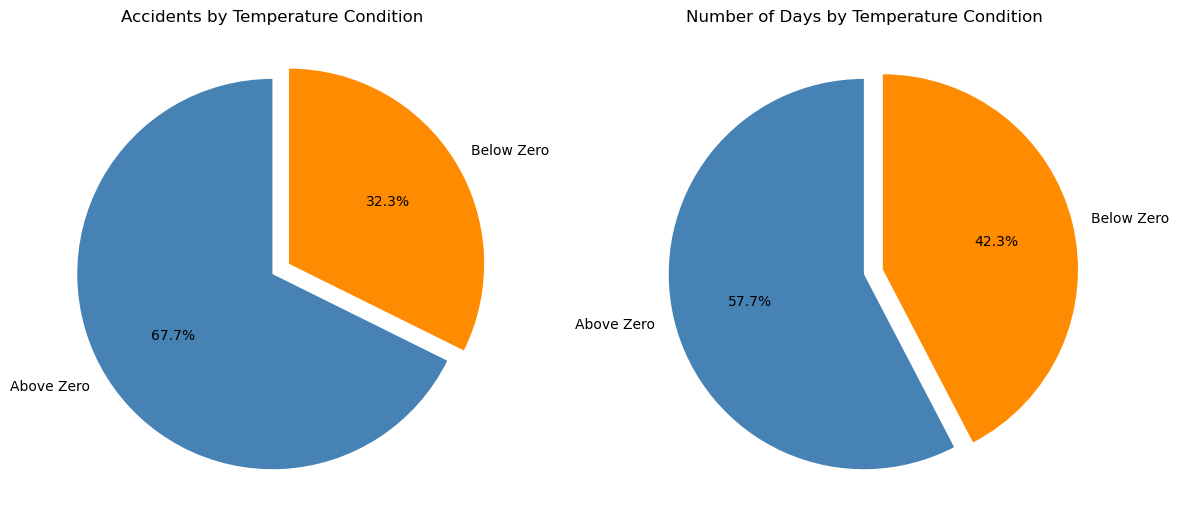

In [36]:
# Let's try to plot these two together. Shall we???

labels = ["Above Zero", "Below Zero"]
explode = (0, 0.1)
# Accident Counts
accident_counts = [5071, 2422]

# Number of Days
number_of_days = [211, 155]

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


axes[0].pie(accident_counts, labels=labels, autopct='%1.1f%%', colors=["steelblue", "darkorange"], startangle=90, explode = explode)
axes[0].set_title("Accidents by Temperature Condition")

axes[1].pie(number_of_days, labels=labels, autopct='%1.1f%%', colors=["steelblue", "darkorange"], startangle=90, explode = explode)
axes[1].set_title("Number of Days by Temperature Condition")

plt.tight_layout()
plt.show()


According to the pie charts above which compare the number of accidents by temperature condition of above or below zero and the number of days in 2024 when the temperature was above or below zero, even though, the temperature in 42.3% days of the year 2024 was below zero, only 32.3% of the accidents accoured in this temperature condition. This could mean that the drivers are more careful when the weather condition is sub-zero.

### Correlation between the temperature and number of accidents

In [43]:
df_correlation2 = df.groupby('Date/Time').agg(
    sum_counts = ('Count','sum'),
    mean_temp = ('Mean Temp (°C)','mean')
).reset_index()
df_correlation2

,Date/Time,sum_counts,mean_temp
0,2024-01-01,15,0.0
1,2024-01-02,20,-2.1
2,2024-01-03,17,-6.2
3,2024-01-04,24,-2.0
4,2024-01-05,23,0.1
...,...,...,...
361,2024-12-27,10,0.4
362,2024-12-28,13,NaN
363,2024-12-29,10,-5.1
364,2024-12-30,16,-5.0


In [44]:
columns_of_interest2 = ['sum_counts', 'mean_temp']
df_corr2 = df_correlation2[columns_of_interest2].corr()

display(df_corr2)

,sum_counts,mean_temp
sum_counts,1.000000,-0.260308
mean_temp,-0.260308,1.000000


**This kinda contracting the pie graphs. WE SHOULD DISCUSS THIS IN THE CLASS TOGETHER and come up with an explaination for what we are seeing**

In [45]:
df.columns

Index(['INCIDENT INFO', 'DESCRIPTION', 'START_DT', 'MODIFIED_DT', 'QUADRANT',
       'Longitude', 'Latitude', 'Count', 'id', 'Point', 'Year_x', 'Month_x',
       'Day_x', 'Weekend?', 'Hour', 'Rush Hour', 'Season', 'Date/Time',
       'Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Year_y',
       'Month_y', 'Day_y', 'Data Quality', 'Max Temp (°C)', 'Max Temp Flag',
       'Min Temp (°C)', 'Min Temp Flag', 'Mean Temp (°C)', 'Mean Temp Flag',
       'Heat Deg Days (°C)', 'Heat Deg Days Flag', 'Cool Deg Days (°C)',
       'Cool Deg Days Flag', 'Total Rain (mm)', 'Total Rain Flag',
       'Total Snow (cm)', 'Total Snow Flag', 'Total Precip (mm)',
       'Total Precip Flag', 'Snow on Grnd (cm)', 'Snow on Grnd Flag',
       'Dir of Max Gust (10s deg)', 'Dir of Max Gust Flag',
       'Spd of Max Gust (km/h)', 'Spd of Max Gust Flag', 'Total Rain (cm)',
       'Below or Above Zero'],
      dtype='object')